In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.optimize as stats2
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
import inspect
import warnings
warnings.filterwarnings('ignore')


In [192]:
df_prueba = pd.DataFrame({
"ES_NO_ES":[np.random.choice(['s','n']) for _ in range(1000)],
"sexo":[np.random.choice(['h','m']) for _ in range(1000)],
"Datos_C":[np.random.choice([0,1]) for _ in range(1000)],
"Datos_D": list(np.random.standard_normal(1000)),
"Datos_E": list(np.random.standard_normal(1000)),
"Datos_Poisson_1": list( stats.poisson.rvs(mu=4, size=1000)),
"Datos_Poisson_3": list( np.random.poisson(lam=10, size=1000)),
"Datos_Geom": list( stats.geom.rvs(0.75, size=1000)),
"Datos_F": [np.random.randint(0,1000) for _ in range(1000)],
"Datos_G": [np.random.randint(0,1000) for _ in range(1000)],
"Datos_cate_A": ['Grupo '+str(np.random.randint(0,6)) for _ in range(1000)],
"Datos_cate_B": ['Grupo '+str(np.random.randint(0,4)) for _ in range(1000)],

})

for i in range(1,6):
    df_prueba['Datos_E'][random.randint(0,23)]=None


for i in range(1,10):
    df_prueba['Datos_F'][random.randint(0,23)]=None

for i in range(0,11):
    df_prueba['Datos_G'][i]=None


In [193]:

class DF_exploracion(pd.DataFrame):

    def __init__(self, *args, **kw):
        super(DF_exploracion, self).__init__(*args, **kw)
        self.cuanti=pd.DataFrame
        self.cuali=pd.DataFrame
        self.dico=pd.DataFrame
        self.cate=pd.DataFrame
        self.eliminado=pd.DataFrame
        self.dummy=pd.DataFrame
        self.df=pd.DataFrame
        self.df_inputado=pd.DataFrame
        self.df_limpio=pd.DataFrame
        self.normal_cuatis=[]
        self.normal_grupos_dico=[]
        self.normal_grupos_cate=[]
        self.discreta=[]
        self.stingg=[]
        
        
        self.porcentaje_nulos_permitido=0.6

    def variables(self):

        dico=[]
        cuantis=[]
        categori=[]
        eliminar=[]
        

        for i in self.columns: 

            try:
                datos=self[i].dropna().to_numpy()
                discreta=True
                for j in datos:
                    if (j%1 !=0):
                        discreta=False
                        break
                    else:
                        continue
                if (discreta):
                    self.discreta.append(i)
            except:
                self.stingg.append(i)

            nulos= (self[i].isnull().sum())/len(self[i])
            
            if ((len(self[i].dropna().unique())==2) and (nulos<=self.porcentaje_nulos_permitido)):
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: DICOTOMICA"
                dico.append(i)

            elif ((len(self[i].dropna().unique())>10) and  (nulos<=self.porcentaje_nulos_permitido)):
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CUANTITATIVA"
                cuantis.append(i)

            elif ( (len(self[i].dropna().unique())<2) or (nulos>self.porcentaje_nulos_permitido)):
                tipo_de_var=f"SOLO {len(self[i].dropna().unique())} TIPOS, NO VALE LA COLUMNA"
                eliminar.append(i)
            else:
                tipo_de_var=f"{len(self[i].dropna().unique())} tipos, posiblemente: CATEGORICA/CUANTI"
                categori.append(i)

            print (f"|  {i} \n|   - Tipo de dato: {self[i].dtype} \n|   - Valores repetidos: {tipo_de_var} \n|   - Nulos: {nulos} \n| ")

        print (f"|----------------------------------------------------------------------------------------------------\n|  TODAS: {self.columns} \n|  DICOTOMICAS: {dico} \n|  CATEGORICAS: {categori} \n|  CUANTITATIVAS: {cuantis} \n|  ELIMINAR: {eliminar}")
        print("|----------------------------------------------------------------------------------------------------")

        


        self.DF_cuantis(cuantis)
        self.DF_cualis(categori+dico)
        self.DF_dicotomica(dico)
        self.DF_categorica(categori)
        self.DF_elimiminado(eliminar)
        self.df=self
        
    def todas_col(self):
        return self.df
    
    def DF_cuantis(self,lista):
        self.cuanti=self[lista]

    def DF_elimiminado(self,lista):
        self.eliminado=self[lista]
        
    def DF_cualis(self,lista):
        self.cuali=self[lista]
        
    def DF_dicotomica(self, lista):
        self.dico=self[lista]
        
    def DF_categorica(self, lista):
        self.cate=self[lista]   



    def limpiar_aux(self):
        
        try:
            df_nuevo=pd.DataFrame
            aux1=list(self.dico.columns)
            aux=[]
            df_nuevo=pd.get_dummies(self.df, columns=aux1)
            
            for columna in df_nuevo.columns:
                for variables in list(self.dico.columns):
                    if variables in columna:
                        aux.append(columna)
                    
            self.dummy=df_nuevo[aux]
            self[aux]=df_nuevo[aux]

            # self.df=self.drop(columns=var, axis='columns')
            # self.df= self[self.columns.difference(self.dico.columns)]
            
            print("********************** self.dummy ************\n")
            print(self.dummy)
            print("\n********************** self.df o todas_las_col() ************\n")
            print(self.df)

        except:
            print("---------------------- ERROR -----------------")



    def limpiar_dummys(self):

        b=False
        lista=list(self.dico.columns)
        for ind, i in enumerate(lista):
                if (ind+1<len(lista)):
                    if( (i in lista [ind+1]) ):
                        b=True
                        break
        if b:
            nombres_nuevos=[]
            if len(lista)>2:
                for ind, i in enumerate(lista):
                    if (ind+1<len(lista)):
                        if( (i in lista [ind+1]) ):
                            nombres_nuevos.append(i.upper())
                        else:
                            nombres_nuevos.append(i)
                    else:
                        nombres_nuevos.append(i)
                        
            aux_df=self.df

            for i,j in zip(lista,nombres_nuevos):
                aux_df.rename(columns={i:j},inplace=True)
                
            self.df=aux_df
            self.dico.columns=nombres_nuevos
            
            self.limpiar_aux()
        else: 
            self.limpiar_aux()



    def estadistica_descriptiva_cuantis(self):

        print("----------------------------------------------------------------------------------------------------\nDESCRIPCIÓN")
        print (self.cuanti.describe())
        print("\n")
        print("----------------------------------------------------------------------------------------------------\nCUARTILES")
        print (self.cuanti.quantile([0.05,0.25,0.5,0.75,0.95]))
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")


        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        # df_auxiliar = self.groupby('sexo').apply(lambda x: pd.Series(shapiro(x), index=['W','P'])).reset_index()
        # print(df_auxiliar)
                
        for a in list(aux1.values):
            
            for b in list(aux.values):
                
                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                agrupado=self.groupby(a)[b]
                titulo=f"Agrupado por {a} y por {b}"
                print(titulo)
                print(agrupado.describe().reset_index())
                # df.groupby(['cat1', 'cat2'])['purchases','sales'].apply(stats.shapiro)
                print("////////////////////////// TEST DE SHAPIRO ////////////////////////////")
                aux_shapiro=(agrupado.apply(stats.shapiro))
                print(aux_shapiro)
        
                
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")


    def estadistica_descriptiva_cualis(self):

        print("\n--------------------- Variables dico ---------------------")
        print("\n")
        for i in self.dico.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")

        print("\n-------------------- Variables categoricas --------------------")
        print("\n")
        for i in self.cate.columns:
            print(f"...........Frecuencia variable {i} ....................")
            print(self[i].value_counts()/(self[i].count()))
            print("\n")
        print("\n\n")

        # crosstab variables cualis con cate
        aux=list(self.cate.columns)

        a=0
        for i in aux:
            a=a+1
            if a<len(aux)/2:
                b=0
                for j in aux[:-1]:
                    b=b+1
                    if b > a:
                        print(f"*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} *********************\n ")
                        tab = pd.crosstab (index=self[i], columns=self[j])
                        x=(tab/tab.sum())
                        print(tab)
                        print("\n")
                        print(f"/////////////////// EN PROPORCION //////////////////\n")
                        print(x)
                        print("\n\n")


    def anova(self):

        aux_cate=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for i in aux_cate:
            for j in aux_cuati:
                try:
                    print(f"\n----------- ANOVA Categoria {i} y variable continua {j} ----------\n")
                    model = ols(f"{j} ~ {i}", data=self).fit()
                    a=sm.stats.anova_lm(model, typ=2)
                    print(a)
                except:
                    print(f"\n - - - - - Fallo en variable {i} y {j} - - - - - - \n")
                    continue




    def Chi(self):

        aux_dico=list(self.dico.columns)

        if len(aux_dico)>1:
            for ind, i in enumerate(aux_dico):
                for j in range(ind+1,len(aux_dico)):
                    chi, p, dof, expected = stats.chi2_contingency(pd.crosstab(self[i],self[aux_dico[j]]), correction=False)
                    print(f"\n-------------- Chi2 entre {i} y {aux_dico[j]} ----------------")
                    print(f"p: {p} \n") 
        else:
            print("******************** No suficientes argumentos ********************")





    def plot_normailidad(self):

        aux=self.cuanti.columns
        for i in aux:
            stats.probplot(self[i], dist="norm", plot=plt)
            plt.title("Probability Plot - " )
            plt.show()
    


    def plot_bigotes(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")

        print("-------------- Graficas de bigotes cualitativas-------------------")
        # fig = plt.figure(figsize=(12, 8))
        
        (self.cuanti).plot(kind='box', title='Variables cuantitativas',figsize=(12, 8))
        plt.show()
        

        print("-------------- Graficas de bigotes por dicotomicas-------------------")   
        
        for a in aux1:

            # fig = plt.figure(figsize=(12, 8))
            self.boxplot(column=list(aux.values), by=a,figsize=(12, 8))
            plt.tight_layout() 
            plt.show()
        
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- Graficas de bigotes por categoricas-------------------") 

        for a in aux2:
            # fig = plt.figure(figsize=(12, 8))
            ax= self.boxplot(column=list(aux.values), by=a, figsize=(12, 8))
            # ax = sns.swarmplot(column=list(aux.values), by=a,data=self, color='#7d0013')
            plt.tight_layout() 
            plt.show()
        print("\n")
        print("----------------------------------------------------------------------------------------------------\n")

        
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")



    def plot_corr(self):

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
        print("----------------------------------------------------------------------------------------------------\n")
        
        print("-------------- MATRIZ DE CORRELACIONES ENTRE CUANTITATIVAS -------------------\n") 

        fig = plt.figure(figsize=(12, 8))
        matrix = self.cuanti.corr().round(2)
        mask = np.triu(np.ones_like(matrix, dtype=bool))
        sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)  
        plt.show()

        print("----------------------------------------------------------------------------------------------------\n")

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")


    def plot_barras(self):
        aux=self.cuanti.columns

        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")
        print("----------------------------------------------------------------------------------------------------\n")

        print("-------------- GRAFICA DE BARRAS DE TODAS LAS CUANTITATIVAS -------------------\n") 
        # fig = plt.figure(figsize=(15, 20))
        self.cuanti.plot.bar(figsize=(18, 8))
        plt.show()

        print("-------------- GRAFICA DE BARRAS CON DISTRIBUCIÓN DE DENSIDAD DE CADA CUANTITATIVA  -------------------\n") 
        for i in list(aux.values):
            fig = plt.figure(figsize=(12, 8))
            print(f"\n.............. GRAFICA DE BARRAS  DE {i} ............\n") 
            ax=self[i].plot.hist(density=True)
            self[i].plot.density(ax=ax)
            plt.show()

        print("----------------------------------------------------------------------------------------------------\n")    
        print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n")


    def todos_plots(self):

        self.plot_bigotes()
        self.plot_corr()
        self.plot_barras()
        self.violines()
        
        

    def violines(self):

        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns

        print("--------------  GRAFICA DE VIOLINES  -------------------\n") 
        sns.set(style="whitegrid")
        for i in aux2:
            for j in aux:
                ax= sns.violinplot(x=self[i], y=self[j], palette="Set2", split=True, inner="quartile",scale="count")
                plt.show()

        print("\n\n/////////-------------- GRAFICA DE VIOLINES POR DICOTOMICAS -------------------/////////////\n") 
        
        for i in aux2:
            for j in aux:
                for k in aux1:
                    ax= sns.violinplot(x=self[i], y=self[j], hue=self[k],palette="Set2", split=True, inner="quartile",scale="count")
                    plt.show()


    def cross_var_cualis_con_ciantis(self):

        aux=list(self.cate.columns)
        aux_cuati=list(self.cuanti.columns)

        for k in aux_cuati:
            a=0
            for i in aux:
                a=a+1
                if a<len(aux)/2:
                    b=0
                    for j in aux[:-1]:
                        b=b+1
                        if b > a:
                            print(f"\n\n*************** TABAL DE VARIABLES CATEGORICAS {i} y {j} con valores de {k} MEDIA *********************\n ")
                            tab = pd.crosstab (index=self[i], columns=self[j],values=self[k],aggfunc=np.mean)
                            print(tab)
                            print("\n\n")

    def nulos(self):
        aux_df=list(self.cuanti.columns)
        aux_DF=self.cuanti
        self.df_inputado=self.df
        for i in aux_df:
            nulos=aux_DF[i].isna().sum()
            total=len(aux_DF[i])
            porcentaje=nulos/total
            if ((nulos>0) and (porcentaje<self.porcentaje_nulos_permitido)):
                percen=aux_DF[i].quantile([0.2,0.8]).to_list()
                self.df_inputado[i]=aux_DF[i].apply(lambda x: ( random.randint ( round(percen[0]) , round(percen[1]) )) if pd.isna(x) else x )
                print(f"\n- Se han inputado {nulos} nulos a la variable {i} (tenía porcentaje de nulos de: {porcentaje}) \n")
            elif (porcentaje>self.porcentaje_nulos_permitido):
                print(f"\n - No se ha podido inputar a la variable {i} porque el porcentaje de nulos era de {porcentaje}\n")
                

    def normalidad(self):
        
        DataF=self.df
        aux1=self.dico.columns
        aux2=self.cate.columns
        aux=self.cuanti.columns
                
        for b in list(aux.values):
            aux_shapiro=(stats.shapiro(DataF[b]))
            if(aux_shapiro.pvalue<0.05):
                print("////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////")
                print("++++++++++++++++++++++++++++  "+ b +"  ++++++++++++++++++++++++++\n")
                titulo=f"Variable cuantitativa {b} y test Shapiro < 0.05"
                print(titulo)
                print(aux_shapiro)
                print("\n")
                print("----------------------------------------------------------------------------------------------------\n")
                self.normal_cuatis.append(b)

        for a in list(aux1.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby(a)[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO DICOTOMICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(aux_shapiro)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_dico.append([a,b])
                    except:
                        continue 

        for a in list(aux2.values):
            for b in list(aux.values):
                    agrupado=DataF.groupby([a])[b]
                    try:
                        aux_shapiro=(agrupado.apply(stats.shapiro))
                        for h in aux_shapiro:
                            if(h.pvalue<0.05):
                                print("////////////////////////// TEST DE SHAPIRO CATEGORICAS ////////////////////////////")
                                print("++++++++++++++++++++++++++++  "+a+" y "+b+"  ++++++++++++++++++++++++++\n")
                                titulo=f"Agrupado por {a} y por {b} y test Shapiro < 0.05"
                                print(titulo)
                                print(h)
                                print("\n")
                                print("----------------------------------------------------------------------------------------------------\n")
                                self.normal_grupos_cate.append([a,b])
                    except:
                        continue 

    def detec_outlaiers(self):
        aux=list(self.cuanti.columns)
        aux_DF=self.cuanti
        for i in aux:
            z = np.abs(stats.zscore(aux_DF[i]))
            print(z)
    





    def seleccionar_distribuciones(self,familia='realall', verbose=False):
        '''
        Parameters
        ----------
        familia : {'realall', 'realline', 'realplus', 'real0to1', 'discreta'}
            realall: distribuciones de la familia `realline` + `realplus`
            realline: distribuciones continuas en el dominio (-inf, +inf)
            realplus: distribuciones continuas en el dominio [0, +inf)
            real0to1: distribuciones continuas en el dominio [0,1]
            discreta: distribuciones discretas
            
        verbose : bool
            Si se muestra información de las distribuciones seleccionadas
            (the default `False`)
        '''
    
        distribuciones = [getattr(stats,d) for d in dir(stats) \
                        if isinstance(getattr(stats,d), (stats.rv_continuous, stats.rv_discrete))]
        
        exclusiones = ['levy_stable', 'vonmises']
        distribuciones = [dist for dist in distribuciones if dist.name not in exclusiones]
                
        dominios = {
            'realall' : [-np.inf, np.inf],
            'realline': [np.inf,np.inf],
            'realplus': [0, np.inf],
            'real0to1': [0, 1], 
            'discreta': [None, None],
        }

        distribucion = []
        tipo = []
        dominio_inf = []
        dominio_sup = []

        for dist in distribuciones:
            distribucion.append(dist.name)
            tipo.append(np.where(isinstance(dist, stats.rv_continuous), 'continua', 'discreta'))
            dominio_inf.append(dist.a)
            dominio_sup.append(dist.b)
        
        info_distribuciones = pd.DataFrame({
                                'distribucion': distribucion,
                                'tipo': tipo,
                                'dominio_inf': dominio_inf,
                                'dominio_sup': dominio_sup
                            })

        info_distribuciones = info_distribuciones \
                            .sort_values(by=['dominio_inf', 'dominio_sup'])\
                            .reset_index(drop=True)
        
        if familia in ['realall', 'realline', 'realplus', 'real0to1']:
            info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='continua']
            condicion = (info_distribuciones['dominio_inf'] == dominios[familia][0]) & \
                        (info_distribuciones['dominio_sup'] == dominios[familia][1]) 
            info_distribuciones = info_distribuciones[condicion].reset_index(drop=True)
            
        if familia in ['discreta']:
            info_distribuciones = info_distribuciones[info_distribuciones['tipo']=='discreta']
            
        seleccion = [dist for dist in distribuciones \
                    if dist.name in info_distribuciones['distribucion'].values]
        
        
        if verbose:
            print("---------------------------------------------------")
            print("       Distribuciones seleccionadas                ")
            print("---------------------------------------------------")
            with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
                print(info_distribuciones)
        
        return seleccion


    def plot_multiple_distribuciones(self, nombre_distribuciones):

        aux=list(self.cuanti.columns)
        fig, ax = plt.subplots(figsize=(15,15))

        for i in aux:
            x=self[i]
            if ax is None:
                fig, ax = plt.subplots(figsize=(7,4))
                
            ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
            ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
            ax.set_title('Ajuste distribuciones')
            ax.set_xlabel('x')
            ax.set_ylabel('Densidad de probabilidad')
            
            for nombre in nombre_distribuciones:
                
                distribucion = getattr(stats, nombre)

                parametros = distribucion.fit(data=x)

                nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                    if not p=='x'] + ["loc","scale"]
                parametros_dict = dict(zip(nombre_parametros, parametros))

                log_likelihood = distribucion.logpdf(x, *parametros).sum()

                aic = -2 * log_likelihood + 2 * len(parametros)
                bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

                x_hat = np.linspace(min(x), max(x), num=100)
                y_hat = distribucion.pdf(x_hat, *parametros)
                ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
            
            ax.legend()
            plt.show()
        


    def fit_discrete(self,datos):

        # self.discreta

        mean = datos.mean()
        var = datos.var()
        likelihoods = {}  
        log_likelihoods = {}

        p = 1 - mean / var  
        r = (1-p) * mean / p



        log_likelihoods['nbinom'] = datos.map(lambda val: stats.nbinom.logpmf(val, r, p)).sum()

        lambda_ = mean

        log_likelihoods['poisson'] = datos.map(lambda val: stats.poisson.logpmf(val, lambda_)).sum()


        best_fit = max(log_likelihoods, key=lambda x: log_likelihoods[x])
        print("**** Best fit between poisson and nbinorm :", best_fit)
        

    
        plt.hist(datos, bins=int(np.max(datos)), density=True, alpha=0.5)

        mean = datos.mean()
        var = datos.var()


        def loss_function_poisson(params, datos_in):

            mu = params[0]

            loss = 0

            for i in range(len(datos_in)):

                loglikelihood = stats.poisson.logpmf(datos_in[i], mu)

                loss_to_add = -loglikelihood

                loss += loss_to_add

            return(loss)




        params0 = np.array([20])
        minimum = stats2.optimize.fmin(loss_function_poisson, params0, args=(datos,))

        mu_fit = minimum[0]

        print("***********  The best mu_fit is:  ",  mu_fit)

        x = list(range(int(np.min(datos)), int(np.max(datos))+1))
        plt.scatter(x, stats.poisson.pmf(x, mu_fit),color="red")
        plt.show()   

        print("\n\n Otras variables discretas:  ",  self.discreta)


    def comparar_distribuciones_caunti_cont(self, ordenar='aic', verbose=False):

            '''
            resultados: data.frame
                distribucion: nombre de la distribución.
                log_likelihood: logaritmo del likelihood del ajuste.
                aic: métrica AIC.
                bic: métrica BIC.
                n_parametros: número de parámetros de la distribución de la distribución.
                parametros: parámetros del tras el ajuste
                
            Raises
            ------
            Exception
                Si `familia` es distinto de 'realall', 'realline', 'realplus', 'real0to1',
                o 'discreta'.
                
            Notes
            -----
            '''
            aux=list(self.cuanti.columns)
            
            for i in aux:
                print(f"\n ******************** Variable: {i} ******************** \n")
                x=self[i]
                distribuciones = self.seleccionar_distribuciones(familia='realall',verbose=verbose)
                distribucion_ = []
                log_likelihood_= []
                aic_ = []
                bic_ = []
                n_parametros_ = []
                parametros_ = []
                
                for j, distribucion in enumerate(distribuciones):
                    
                    # print(f"{j+1}/{len(distribuciones)} Ajustando distribución: {distribucion.name}")
                    
                    try:
                        parametros = distribucion.fit(data=x)
                        nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                            if not p=='x'] + ["loc","scale"]
                        parametros_dict = dict(zip(nombre_parametros, parametros))
                        log_likelihood = distribucion.logpdf(x, *parametros).sum()
                        aic = -2 * log_likelihood + 2 * len(parametros)
                        bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)
                        
                        distribucion_.append(distribucion.name)
                        log_likelihood_.append(log_likelihood)
                        aic_.append(aic)
                        bic_.append(bic)
                        n_parametros_.append(len(parametros))
                        parametros_.append(parametros_dict)
                        
                        resultados = pd.DataFrame({
                                        'distribucion': distribucion_,
                                        'log_likelihood': log_likelihood_,
                                        'aic': aic_,
                                        'bic': bic_,
                                        'n_parametros': n_parametros_,
                                        'parametros': parametros_,
                            
                                    })
                        
                        resultados = resultados.sort_values(by=ordenar).reset_index(drop=True)

                        
                        
                    except Exception as e:
                        print(f"Error al tratar de ajustar la distribución {distribucion.name}")
                        print(e)
                        print("")

                nombre_distribuciones=resultados['distribucion'][:5]
                fig, ax = plt.subplots(figsize=(7,4))
                
                
                ax.hist(x=x, density=True, bins=30, color="#3182bd", alpha=0.5)
                ax.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
                ax.set_title('Ajuste distribuciones')
                ax.set_xlabel('x')
                ax.set_ylabel('Densidad de probabilidad')
                
                for nombre in nombre_distribuciones:
                    
                    distribucion = getattr(stats, nombre)

                    parametros = distribucion.fit(data=x)

                    nombre_parametros = [p for p in inspect.signature(distribucion._pdf).parameters \
                                        if not p=='x'] + ["loc","scale"]
                    parametros_dict = dict(zip(nombre_parametros, parametros))

                    log_likelihood = distribucion.logpdf(x, *parametros).sum()

                    aic = -2 * log_likelihood + 2 * len(parametros)
                    bic = -2 * log_likelihood + np.log(x.shape[0]) * len(parametros)

                    x_hat = np.linspace(min(x), max(x), num=100)
                    y_hat = distribucion.pdf(x_hat, *parametros)
                    ax.plot(x_hat, y_hat, linewidth=2, label=distribucion.name)
            
                ax.legend()
                plt.show()

                print("\n")
                print(resultados.head(5))    
                print("\n------------------------------------------------------------------\n")

            
        


# CREACIÓN DE LA CLASE

In [194]:
ejemplo=DF_exploracion(df_prueba)


In [195]:
ejemplo.cuanti.columns

# DEFINICIÓN DE LAS VARIABLES

In [196]:
ejemplo.variables()


|  ES_NO_ES 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  sexo 
|   - Tipo de dato: object 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  Datos_C 
|   - Tipo de dato: int32 
|   - Valores repetidos: 2 tipos, posiblemente: DICOTOMICA 
|   - Nulos: 0.0 
| 
|  Datos_D 
|   - Tipo de dato: float64 
|   - Valores repetidos: 1000 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_E 
|   - Tipo de dato: float64 
|   - Valores repetidos: 995 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.005 
| 
|  Datos_Poisson_1 
|   - Tipo de dato: int64 
|   - Valores repetidos: 12 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_Poisson_3 
|   - Tipo de dato: int32 
|   - Valores repetidos: 20 tipos, posiblemente: CUANTITATIVA 
|   - Nulos: 0.0 
| 
|  Datos_Geom 
|   - Tipo de dato: int64 
|   - Valores repetidos: 6 tipos, posiblemente: CATEGORICA/CUANTI 
|   - Nulos: 0

## Creación de variables dummys a traves de dicotómicas

In [197]:
ejemplo.limpiar_dummys()

********************** self.dummy ************

     ES_NO_ES_n  ES_NO_ES_s  sexo_h  sexo_m  Datos_C_0  Datos_C_1
0             0           1       1       0          1          0
1             0           1       0       1          0          1
2             0           1       1       0          1          0
3             1           0       1       0          1          0
4             0           1       1       0          1          0
..          ...         ...     ...     ...        ...        ...
995           1           0       0       1          1          0
996           0           1       1       0          1          0
997           0           1       0       1          1          0
998           0           1       0       1          0          1
999           0           1       0       1          1          0

[1000 rows x 6 columns]

********************** self.df o todas_las_col() ************

    ES_NO_ES sexo  Datos_C   Datos_D   Datos_E  Datos_Poisson_1  \
0   

## Revisión de todas las columnas

In [198]:
# ejemplo.df
# ejemplo.cuanti
# ejemplo.dummy
# ejemplo.dico
ejemplo.df


,ES_NO_ES,sexo,Datos_C,Datos_D,Datos_E,Datos_Poisson_1,Datos_Poisson_3,Datos_Geom,Datos_F,Datos_G,Datos_cate_A,Datos_cate_B,ES_NO_ES_n,ES_NO_ES_s,sexo_h,sexo_m,Datos_C_0,Datos_C_1
0,s,h,0,0.383966,-1.499891,4,12,1,700.0,NaN,Grupo 3,Grupo 1,0,1,1,0,1,0
1,s,m,1,0.073875,0.180736,9,9,1,226.0,NaN,Grupo 5,Grupo 3,0,1,0,1,0,1
2,s,h,0,0.267019,1.023954,1,6,1,NaN,NaN,Grupo 5,Grupo 2,0,1,1,0,1,0
3,n,h,0,0.028572,0.118609,5,8,1,864.0,NaN,Grupo 0,Grupo 2,1,0,1,0,1,0
4,s,h,0,0.078159,0.589924,7,11,1,NaN,NaN,Grupo 2,Grupo 1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,n,m,0,1.408903,1.533858,1,13,2,997.0,819.0,Grupo 2,Grupo 2,1,0,0,1,1,0
996,s,h,0,0.181611,0.845556,1,9,1,72.0,971.0,Grupo 4,Grupo 1,0,1,1,0,1,0
997,s,m,0,0.936830,-1.120938,3,11,1,218.0,341.0,Grupo 3,Grupo 3,0,1,0,1,1,0
998,s,m,1,-2.220463,-1.383916,3,5,1,392.0,141.0,Grupo 2,Grupo 2,0,1,0,1,0,1


## Revisión de variables agrupadas automaticamente

In [199]:
print(f" Datos con distribución discreta: {ejemplo.discreta}")
print(f"Datos de tipos string seguramente: {ejemplo.stingg}")
        

 Datos con distribución discreta: ['Datos_C', 'Datos_Poisson_1', 'Datos_Poisson_3', 'Datos_Geom', 'Datos_F', 'Datos_G']
Datos de tipos string seguramente: ['ES_NO_ES', 'sexo', 'Datos_cate_A', 'Datos_cate_B']


# ESTADISTICA DESCRIPTIVA

In [200]:
ejemplo.estadistica_descriptiva_cuantis()

----------------------------------------------------------------------------------------------------
DESCRIPCIÓN
           Datos_D     Datos_E  Datos_Poisson_1  Datos_Poisson_3     Datos_F  \
count  1000.000000  995.000000      1000.000000      1000.000000  993.000000   
mean     -0.045072   -0.058971         4.026000         9.983000  525.011078   
std       1.044149    1.001511         2.023714         3.167767  283.733787   
min      -3.550741   -3.097507         0.000000         2.000000    3.000000   
25%      -0.688489   -0.716736         3.000000         8.000000  286.000000   
50%      -0.041049   -0.056493         4.000000        10.000000  526.000000   
75%       0.632945    0.624821         5.000000        12.000000  775.000000   
max       3.139565    2.953807        11.000000        23.000000  999.000000   

          Datos_G  
count  989.000000  
mean   489.249747  
std    293.942122  
min      1.000000  
25%    232.000000  
50%    477.000000  
75%    753.000000  
max   

In [201]:
ejemplo.estadistica_descriptiva_cualis()


--------------------- Variables dico ---------------------


...........Frecuencia variable ES_NO_ES ....................
s    0.51
n    0.49
Name: ES_NO_ES, dtype: float64


...........Frecuencia variable sexo ....................
m    0.504
h    0.496
Name: sexo, dtype: float64


...........Frecuencia variable Datos_C ....................
0    0.548
1    0.452
Name: Datos_C, dtype: float64



-------------------- Variables categoricas --------------------


...........Frecuencia variable Datos_Geom ....................
1    0.749
2    0.186
3    0.048
4    0.012
5    0.004
9    0.001
Name: Datos_Geom, dtype: float64


...........Frecuencia variable Datos_cate_A ....................
Grupo 0    0.180
Grupo 5    0.174
Grupo 4    0.172
Grupo 2    0.168
Grupo 1    0.155
Grupo 3    0.151
Name: Datos_cate_A, dtype: float64


...........Frecuencia variable Datos_cate_B ....................
Grupo 1    0.273
Grupo 0    0.255
Grupo 3    0.239
Grupo 2    0.233
Name: Datos_cate_B, dtype: float64

In [202]:
ejemplo.cross_var_cualis_con_ciantis()



*************** TABAL DE VARIABLES CATEGORICAS Datos_Geom y Datos_cate_A con valores de Datos_D MEDIA *********************
 
Datos_cate_A   Grupo 0   Grupo 1   Grupo 2   Grupo 3   Grupo 4   Grupo 5
Datos_Geom                                                              
1            -0.174681  0.073920  0.068846 -0.156982  0.042336  0.012015
2            -0.168283  0.295792 -0.109798 -0.223291 -0.109427 -0.183906
3            -0.083147 -0.510425 -0.128159 -0.001193 -0.702539 -0.215816
4            -0.472978 -0.248708  0.915192 -0.144508  0.049403 -1.326015
5            -0.635971       NaN       NaN       NaN  0.402373 -0.413932
9             0.223552       NaN       NaN       NaN       NaN       NaN





*************** TABAL DE VARIABLES CATEGORICAS Datos_Geom y Datos_cate_A con valores de Datos_E MEDIA *********************
 
Datos_cate_A   Grupo 0   Grupo 1   Grupo 2   Grupo 3   Grupo 4   Grupo 5
Datos_Geom                                                              
1          

## Variables normales y no normales

In [203]:
ejemplo.normalidad()

////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////
++++++++++++++++++++++++++++  Datos_Poisson_1  ++++++++++++++++++++++++++

Variable cuantitativa Datos_Poisson_1 y test Shapiro < 0.05
ShapiroResult(statistic=0.9565339088439941, pvalue=1.20674269366258e-16)


----------------------------------------------------------------------------------------------------

////////////////////////// TEST DE SHAPIRO CUANTITATIVAS ////////////////////////////
++++++++++++++++++++++++++++  Datos_Poisson_3  ++++++++++++++++++++++++++

Variable cuantitativa Datos_Poisson_3 y test Shapiro < 0.05
ShapiroResult(statistic=0.9815027117729187, pvalue=5.869263963731441e-10)


----------------------------------------------------------------------------------------------------

////////////////////////// TEST DE SHAPIRO DICOTOMICAS ////////////////////////////
++++++++++++++++++++++++++++  ES_NO_ES y Datos_Poisson_1  ++++++++++++++++++++++++++

Agrupado por ES_NO_ES y por Datos

## Agrupación normal por categoricas

In [204]:
ejemplo.normal_grupos_cate

[['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_1'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_Poisson_3'],
 ['Datos_cate_A', 'Datos_F'],
 ['Datos_cate_A', 'Datos_G'],
 ['Datos_cate_A', 'Datos_G'],
 ['Datos_cate_B', 'Datos_Poisson_1'],
 ['Datos_cate_B', 'Datos_Poisson_1'],
 ['Datos_cate_B', 'Datos_Poisson_1'],
 ['Datos_cate_B', 'Datos_Poisson_1'],
 ['Datos_cate_B', 'Datos_Poisson_3'],
 ['Datos_cate_B', 'Datos_Poisson_3'],
 ['Datos_cate_B', 'Datos_Poisson_3'],
 ['Datos_cate_B', 'Datos_Poisson_3']]

## Agrupación normalidad por dicotomicas

In [205]:
ejemplo.normal_grupos_dico

[['ES_NO_ES', 'Datos_Poisson_1'],
 ['ES_NO_ES', 'Datos_Poisson_1'],
 ['ES_NO_ES', 'Datos_Poisson_3'],
 ['ES_NO_ES', 'Datos_Poisson_3'],
 ['sexo', 'Datos_Poisson_1'],
 ['sexo', 'Datos_Poisson_1'],
 ['sexo', 'Datos_Poisson_3'],
 ['sexo', 'Datos_Poisson_3'],
 ['Datos_C', 'Datos_Poisson_1'],
 ['Datos_C', 'Datos_Poisson_1'],
 ['Datos_C', 'Datos_Poisson_3'],
 ['Datos_C', 'Datos_Poisson_3']]

## Inputar datos en columnas variables cuantitativas

In [206]:
df_prueba[['Datos_E','Datos_F','Datos_G']]

,Datos_E,Datos_F,Datos_G
0,-1.499891,700.0,NaN
1,0.180736,226.0,NaN
2,1.023954,NaN,NaN
3,0.118609,864.0,NaN
4,0.589924,NaN,NaN
...,...,...,...
995,1.533858,997.0,819.0
996,0.845556,72.0,971.0
997,-1.120938,218.0,341.0
998,-1.383916,392.0,141.0


In [207]:
ejemplo.nulos()


- Se han inputado 5 nulos a la variable Datos_E (tenía porcentaje de nulos de: 0.005) 


- Se han inputado 7 nulos a la variable Datos_F (tenía porcentaje de nulos de: 0.007) 


- Se han inputado 11 nulos a la variable Datos_G (tenía porcentaje de nulos de: 0.011) 



In [208]:
ejemplo.df_inputado[['Datos_E','Datos_F','Datos_G']]

,Datos_E,Datos_F,Datos_G
0,-1.499891,700.0,567.0
1,0.180736,226.0,220.0
2,1.023954,411.0,654.0
3,0.118609,864.0,618.0
4,0.589924,427.0,577.0
...,...,...,...
995,1.533858,997.0,819.0
996,0.845556,72.0,971.0
997,-1.120938,218.0,341.0
998,-1.383916,392.0,141.0


## Ajustar a distribuciones variables cuantitativas (No puede haber nulos)


 ******************** Variable: Datos_D ******************** 

Error al tratar de ajustar la distribución loguniform
Optimization converged to parameters that are outside the range allowed by the distribution.

Error al tratar de ajustar la distribución reciprocal
Optimization converged to parameters that are outside the range allowed by the distribution.



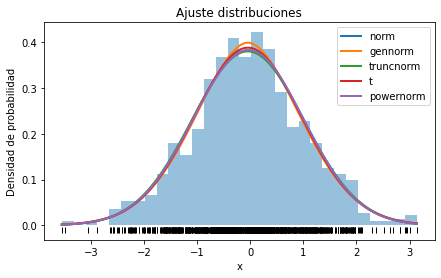



  distribucion  log_likelihood          aic          bic  n_parametros  \
0         norm    -1461.640656  2927.281312  2937.096823             2   
1      gennorm    -1460.979919  2927.959839  2942.683104             3   
2    truncnorm    -1460.042727  2928.085454  2947.716475             4   
3            t    -1461.398581  2928.797162  2943.520428             3   
4    powernorm    -1461.605991  2929.211982  2943.935247             3   

                                          parametros  
0  {'loc': -0.04507177775064212, 'scale': 1.04362...  
1  {'beta': 1.8440286772818744, 'loc': -0.0457406...  
2  {'a': -3.3308561638248557, 'b': 3.028533662911...  
3  {'df': 51.94372952614857, 'loc': -0.0448813995...  
4  {'c': 1.1011009183760425, 'loc': 0.04687934037...  

------------------------------------------------------------------


 ******************** Variable: Datos_E ******************** 

Error al tratar de ajustar la distribución loguniform
Optimization converged to parameters

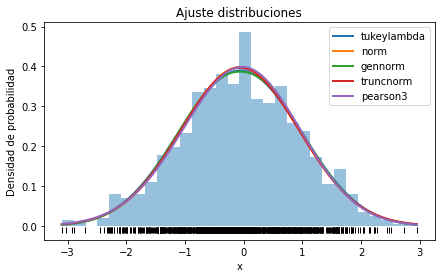



  distribucion  log_likelihood          aic          bic  n_parametros  \
0  tukeylambda    -1417.925684  2841.851369  2856.574635             3   
1         norm    -1419.008355  2842.016710  2851.832220             2   
2      gennorm    -1418.664830  2843.329660  2858.052925             3   
3    truncnorm    -1417.678509  2843.357018  2862.988039             4   
4     pearson3    -1418.679108  2843.358216  2858.081482             3   

                                          parametros  
0  {'lam': 0.17579251052757042, 'loc': -0.0605427...  
1  {'loc': -0.05767596170462498, 'scale': 1.00006...  
2  {'beta': 2.130642143123225, 'loc': -0.05838750...  
3  {'a': -3.014489988331028, 'b': 3.7226828072642...  
4  {'skew': -0.06797230983029698, 'loc': -0.05766...  

------------------------------------------------------------------


 ******************** Variable: Datos_Poisson_1 ******************** 



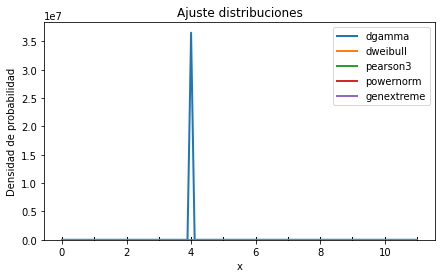



  distribucion  log_likelihood          aic          bic  n_parametros  \
0       dgamma     1105.005406 -2204.010811 -2189.287545             3   
1     dweibull    -2024.807670  4055.615340  4070.338606             3   
2     pearson3    -2090.274839  4186.549677  4201.272943             3   
3    powernorm    -2090.900150  4187.800300  4202.523566             3   
4   genextreme    -2090.973096  4187.946193  4202.669459             3   

                                          parametros  
0  {'a': 0.44720757835323965, 'loc': 3.9999999999...  
1  {'c': 0.9807509773827816, 'loc': 3.99999999999...  
2  {'skew': 0.6496932671288431, 'loc': 4.02598307...  
3  {'c': 0.03139907729431342, 'loc': 0.6212101885...  
4  {'c': 0.10488202185708641, 'loc': 3.1680886723...  

------------------------------------------------------------------


 ******************** Variable: Datos_Poisson_3 ******************** 



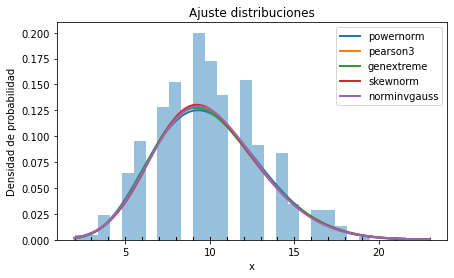



   distribucion  log_likelihood          aic          bic  n_parametros  \
0     powernorm    -2557.182099  5120.364198  5135.087464             3   
1      pearson3    -2557.388227  5120.776453  5135.499719             3   
2    genextreme    -2557.691800  5121.383599  5136.106865             3   
3      skewnorm    -2558.181962  5122.363924  5137.087190             3   
4  norminvgauss    -2557.638416  5123.276833  5142.907854             4   

                                          parametros  
0  {'c': 0.12117872435377591, 'loc': 5.7554157913...  
1  {'skew': 0.4242946068817682, 'loc': 9.98302296...  
2  {'c': 0.15625230974732382, 'loc': 8.6953516342...  
3  {'a': 1.876885975141233, 'loc': 6.834412212418...  
4  {'a': 81.60332572433467, 'b': 72.4700543462511...  

------------------------------------------------------------------


 ******************** Variable: Datos_F ******************** 



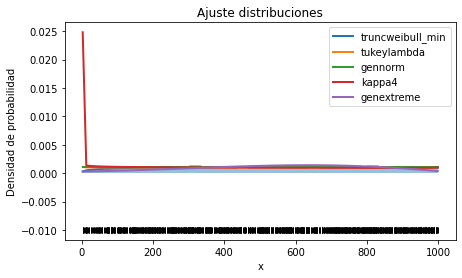



       distribucion  log_likelihood           aic           bic  n_parametros  \
0  truncweibull_min    -6901.478430  13812.956860  13837.495636             5   
1       tukeylambda    -6903.605396  13813.210792  13827.934058             3   
2           gennorm    -6903.747518  13813.495037  13828.218303             3   
3            kappa4    -6907.646896  13823.293792  13842.924813             4   
4        genextreme    -7030.897382  14067.794763  14082.518029             3   

                                          parametros  
0  {'c': 1.282994880744433, 'a': 0.00117757366504...  
1  {'lam': 1.005475747876491, 'loc': 501.00001142...  
2  {'beta': 48232611.14056882, 'loc': 500.9999889...  
3  {'h': 1.0993370893927885, 'k': 1.0165828883464...  
4  {'c': 0.49959403248712386, 'loc': 455.91185731...  

------------------------------------------------------------------


 ******************** Variable: Datos_G ******************** 



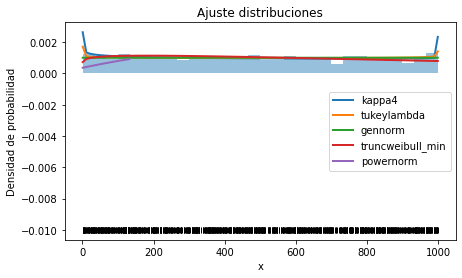



       distribucion  log_likelihood           aic           bic  n_parametros  \
0            kappa4    -6902.434279  13812.868557  13832.499578             4   
1       tukeylambda    -6903.751394  13813.502789  13828.226055             3   
2           gennorm    -6905.753567  13817.507134  13832.230400             3   
3  truncweibull_min    -6911.197496  13832.394993  13856.933769             5   
4         powernorm    -7067.337477  14140.674953  14155.398219             3   

                                          parametros  
0  {'h': 1.0981352774527156, 'k': 1.0270906267468...  
1  {'lam': 1.0743241216777415, 'loc': 500.0000920...  
2  {'beta': 45774991.40847379, 'loc': 500.0000023...  
3  {'c': 1.1078262955959586, 'a': 0.0007810554466...  
4  {'c': 0.00016175232236612173, 'loc': -73.48936...  

------------------------------------------------------------------



In [209]:
ejemplo.comparar_distribuciones_caunti_cont()

## Ajustar a distribuciones variables discretas (No puede haber nulos) (Solo poisson y binomial)

**** Best fit between poisson and nbinorm : poisson
Optimization terminated successfully.
         Current function value: 2090.661043
         Iterations: 21
         Function evaluations: 42
***********  The best mu_fit is:   4.0260009765625


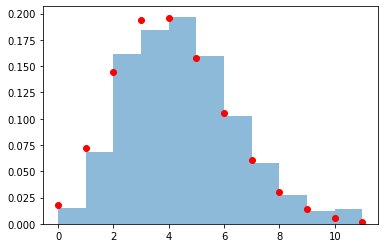



 Otras variables discretas:   ['Datos_C', 'Datos_Poisson_1', 'Datos_Poisson_3', 'Datos_Geom', 'Datos_F', 'Datos_G']


In [210]:
ejemplo.fit_discrete(df_prueba["Datos_Poisson_1"])

## Quitar outlaiers

# PLOTS

In [211]:
#ejemplo.todos_plots()

In [212]:
# ejemplo.plot_bigotes()

In [213]:
# ejemplo.plot_barras()

In [214]:
# ejemplo.plot_corr()

In [215]:
# ejemplo.violines()

In [216]:
# ejemplo.plot_normailidad()

# TEST ESTADISTICOS

## Chi2

In [217]:
ejemplo.Chi()


-------------- Chi2 entre ES_NO_ES y sexo ----------------
p: 0.7005173429856566 


-------------- Chi2 entre ES_NO_ES y Datos_C ----------------
p: 0.7525972159242479 


-------------- Chi2 entre sexo y Datos_C ----------------
p: 0.7805794646217149 



## T_student

# Wilconxon

## Anova

In [218]:
ejemplo.anova()


----------- ANOVA Categoria Datos_Geom y variable continua Datos_D ----------

                 sum_sq     df         F    PR(>F)
Datos_Geom     1.964777    1.0  1.803588  0.179585
Residual    1087.192489  998.0       NaN       NaN

----------- ANOVA Categoria Datos_Geom y variable continua Datos_E ----------

                sum_sq     df         F    PR(>F)
Datos_Geom    0.223700    1.0  0.223271  0.636662
Residual    999.915954  998.0       NaN       NaN

----------- ANOVA Categoria Datos_Geom y variable continua Datos_Poisson_1 ----------

                 sum_sq     df         F    PR(>F)
Datos_Geom     8.735294    1.0  2.135367  0.144251
Residual    4082.588706  998.0       NaN       NaN

----------- ANOVA Categoria Datos_Geom y variable continua Datos_Poisson_3 ----------

                  sum_sq     df         F    PR(>F)
Datos_Geom      8.288821    1.0  0.825868  0.363689
Residual    10016.422179  998.0       NaN       NaN

----------- ANOVA Categoria Datos_Geom y variable c